In [1]:
%load_ext autoreload
%autoreload 2

# from circuit_breaking.src import *
# import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
# from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
# from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 


/Users/phillipguo/anaconda3/envs/bufn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

# tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
# tokenizer.pad_token_id = tokenizer.eos_token_id
# tokenizer.padding_side = "right"

n_layers = 28
n_heads = 16

# print(torch.cuda.memory_allocated() / 1024**3)

In [3]:
maintain_sport = None
inject_sport = None
# inject_sport = "golf"

# forget_sport=None
# forget_athletes = 16
# if inject_sport is not None:
#     save_dir = f"results/localized_finetuning_injection_{forget_athletes}_athletes"
# else:
#     save_dir = f"results/localized_finetuning_{forget_athletes}_athletes"
# forget_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": True, "train_test_split": False}
# maintain_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": False, "train_test_split": True}

forget_sport="basketball"
forget_athletes = None
if inject_sport is not None:
    save_dir = f"results/localized_finetuning_injection_{forget_sport}"
else:
    save_dir = f"results/localized_finetuning_{forget_sport}"
forget_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": True, "train_test_split": True}
maintain_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": False, "train_test_split": True}


In [4]:
# from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict, get_parameter, apply_localized_gradients

import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
print(ap_graph.keys())

# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
print(ct_graph)

beta = 3
top_p = 5
combine_heads = True

localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
# localization_types = ["localized_ap", "localized_ct"]
# localization_types = ["manual_interp", "nonlocalized"]
# localization_types = ["manual_interp"]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
color_map = {"localized_ap": colors[0], "localized_ct": colors[1], "random": colors[2], "manual_interp": colors[3], "nonlocalized": colors[4], "all_mlps": colors[5]}
formal_name_dict = {"localized_ap": "Localized AP", "localized_ct": "Localized CT", "random": "Random", "manual_interp": "Manual Interp", "nonlocalized": "Nonlocalized", "all_mlps": "All MLPs"}

type_to_marker = {
    'localized_ap': 'o',
    'localized_ct': 'v',
    'random': '^',
    'manual_interp': 's',
    'all_mlps': 'D',
    'nonlocalized': 'P'
}
from collections import defaultdict
# from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo

# combine_heads = True
top_p = 5
learning_rate = 1e-5
n_epochs = 50
# max_gpu_batch_size=8
beta = 3

training_dict = {}

for localization_type in localization_types:
    with open(f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", "rb") as f:
        training_dict[localization_type] = pickle.load(f)
        # pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

In [5]:
with open(f"{save_dir}/eval_metrics.pkl", "rb") as f:
    eval_metrics = pickle.load(f)
print(eval_metrics)

{'task_losses': {'localized_ap': {'induction': 0.694140625, 'pile': 2.284375, 'forget_sport': 16.8625, 'maintain_sport': 0.00015482902526855468}, 'localized_ct': {'induction': 0.4892578125, 'pile': 2.309375, 'forget_sport': 11.4125, 'maintain_sport': 0.001575469970703125}, 'random': {'induction': 0.47861328125, 'pile': 2.3296875, 'forget_sport': 1.415625, 'maintain_sport': 0.21279296875}, 'manual_interp': {'induction': 0.679296875, 'pile': 2.2734375, 'forget_sport': 12.175, 'maintain_sport': 0.0010967254638671875}, 'all_mlps': {'induction': 0.903125, 'pile': 2.17265625, 'forget_sport': 9.88125, 'maintain_sport': 0.051180267333984376}, 'nonlocalized': {'induction': 0.86328125, 'pile': 2.2734375, 'forget_sport': 9.2375, 'maintain_sport': 0.0285675048828125}}, 'task_accuracies': {'localized_ap': {'induction': 0.996875, 'pile': 0.5323356747627258, 'forget_sport': 7.862108759582043e-08, 'maintain_sport': 1.0}, 'localized_ct': {'induction': 0.990625, 'pile': 0.52143974006176, 'forget_sport':

In [6]:
eval_metrics['adversarial_evals']

{'localized_ap': {'Normal': {'forget': 4.695355892181397e-06, 'maintain': 1.0},
  'MC': {'forget': 0.7671874999999999, 'maintain': 0.9390625},
  'Capitalized': {'forget': 0.00024160146713256834, 'maintain': 1.0},
  'Dashed': {'forget': 0.8532724618911743, 'maintain': 0.9369702339172363}},
 'localized_ct': {'Normal': {'forget': 0.2005859375,
   'maintain': 0.9984374999999999},
  'MC': {'forget': 0.84921875, 'maintain': 0.95390625},
  'Capitalized': {'forget': 0.19594726562499998,
   'maintain': 0.9984374999999999},
  'Dashed': {'forget': 0.8742952346801758, 'maintain': 0.9667640686035155}},
 'random': {'Normal': {'forget': 0.95234375, 'maintain': 0.9796874999999999},
  'MC': {'forget': 0.821875, 'maintain': 0.940625},
  'Capitalized': {'forget': 0.9421875000000001,
   'maintain': 0.9843750000000001},
  'Dashed': {'forget': 0.9577271938323975, 'maintain': 0.6906817317008972}},
 'manual_interp': {'Normal': {'forget': 0.00219879150390625,
   'maintain': 0.9953125},
  'MC': {'forget': 0.110

In [7]:
with open(f"{save_dir}/full_capability_dict.pkl", "rb") as f:
    capability_dict = pickle.load(f)
print(capability_dict)
mmlus = {model_name: capability_dict[model_name]['mmlu'] for model_name in capability_dict}
print(mmlus)

{'localized_ap': {'sciq': {'acc,none': 0.951, 'acc_stderr,none': 0.006829761756140929, 'acc_norm,none': 0.942, 'acc_norm_stderr,none': 0.007395315455792946, 'alias': 'sciq'}, 'mmlu': {'acc,none': 0.6022646346674263, 'acc_stderr,none': 0.0038790640723546507, 'alias': 'mmlu'}, 'mmlu_humanities': {'alias': ' - humanities', 'acc,none': 0.5358129649309246, 'acc_stderr,none': 0.006699508352071364}, 'mmlu_formal_logic': {'alias': '  - formal_logic', 'acc,none': 0.42857142857142855, 'acc_stderr,none': 0.04426266681379909}, 'mmlu_high_school_european_history': {'alias': '  - high_school_european_history', 'acc,none': 0.7454545454545455, 'acc_stderr,none': 0.03401506715249039}, 'mmlu_high_school_us_history': {'alias': '  - high_school_us_history', 'acc,none': 0.7647058823529411, 'acc_stderr,none': 0.029771775228145635}, 'mmlu_high_school_world_history': {'alias': '  - high_school_world_history', 'acc,none': 0.7848101265822784, 'acc_stderr,none': 0.026750826994676152}, 'mmlu_international_law': {

## Make Graphics of saved results

In [8]:
training_dict['all_mlps']['test_losses']['forget_sport']

[10.3875,
 14.4875,
 20.6,
 14.15,
 7.69375,
 7.91875,
 7.4375,
 7.775,
 8.9375,
 8.525,
 9.725,
 9.175,
 8.5875,
 7.6875,
 7.8,
 8.03125,
 7.6875,
 8.0,
 8.5625,
 8.625,
 8.7,
 8.8375,
 8.6625,
 9.0,
 8.9125,
 9.175,
 9.125,
 9.575,
 9.6625,
 9.8875,
 9.8125,
 9.725,
 9.725,
 10.1,
 10.2375,
 9.9875,
 9.875,
 9.825,
 10.05,
 9.85,
 10.1,
 10.1,
 9.775,
 9.825,
 10.05,
 9.85,
 9.975,
 9.75,
 9.9375,
 9.875]

In [9]:
# retraining results
n_relearn_iters = 10
n_relearn_athletes = 2

with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", "rb") as f:
    # pickle.dump({"relearning_regular_results": relearning_regular_results, "relearning_adversarial_results": relearning_adversarial_results, "relearning_side_effect_results": relearning_side_effect_results, "relearning_train_results": relearning_train_results, "relearning_test_results": relearning_test_results}, f)
    relearning_results = pickle.load(f)
    relearning_regular_results = relearning_results["relearning_regular_results"]
    relearning_adversarial_results = relearning_results["relearning_adversarial_results"]
    relearning_side_effect_results = relearning_results["relearning_side_effect_results"]
    relearning_train_results = relearning_results["relearning_train_results"]
    relearning_test_results = relearning_results["relearning_test_results"]

In [10]:
if inject_sport is None:
    if forget_sport is not None:
        base_table_results = {
            "localized_ap": {
                'MMLU': 0.6023,
                'adversarial': {
                    'Normal': {'forget': 0.0000, 'maintain': 1.0000},
                    'MC': {'forget': 0.7672, 'maintain': 0.9391},
                    'Capitalized': {'forget': 0.0002, 'maintain': 1.0000},
                    'Dashed': {'forget': 0.8533, 'maintain': 0.9370}
                }
            },
            "localized_ct": {
                'MMLU': 0.6114,
                'adversarial': {
                    'Normal': {'forget': 0.2006, 'maintain': 0.9984},
                    'MC': {'forget': 0.8492, 'maintain': 0.9539},
                    'Capitalized': {'forget': 0.1959, 'maintain': 0.9984},
                    'Dashed': {'forget': 0.8743, 'maintain': 0.9668}
                }
            },
            "random": {
                'MMLU': 0.6119,
                'adversarial': {
                    'Normal': {'forget': 0.9523, 'maintain': 0.9797},
                    'MC': {'forget': 0.8219, 'maintain': 0.9406},
                    'Capitalized': {'forget': 0.9422, 'maintain': 0.9844},
                    'Dashed': {'forget': 0.9577, 'maintain': 0.6907}
                }
            },
            "manual_interp": {
                'MMLU': 0.6131,
                'adversarial': {
                    'Normal': {'forget': 0.0022, 'maintain': 0.9953},
                    'MC': {'forget': 0.1101, 'maintain': 0.6563},
                    'Capitalized': {'forget': 0.0013, 'maintain': 0.9961},
                    'Dashed': {'forget': 0.2951, 'maintain': 0.8259}
                }
            },
            "all_mlps": {
                'MMLU': 0.6064,
                'adversarial': {
                    'Normal': {'forget': 0.0002, 'maintain': 0.9937},
                    'MC': {'forget': 0.2793, 'maintain': 0.3188},
                    'Capitalized': {'forget': 0.0009, 'maintain': 0.9992},
                    'Dashed': {'forget': 0.0991, 'maintain': 0.8272}
                }
            },
            "nonlocalized": {
                'MMLU': 0.5953,
                'adversarial': {
                    'Normal': {'forget': 0.0005, 'maintain': 0.9852},
                    'MC': {'forget': 0.1963, 'maintain': 0.2848},
                    'Capitalized': {'forget': 0.0020, 'maintain': 0.9906},
                    'Dashed': {'forget': 0.1229, 'maintain': 0.8202}
                }
            }
        }

    else:
        base_table_results = {
            "localized_ap": {
                'MMLU': 0.614,
                'adversarial': {
                    'Normal': {'forget': 0.941, 'maintain': 0.964},
                    'MC': {'forget': 0.934, 'maintain': 0.909},
                    'Capitalized': {'forget': 0.938, 'maintain': 0.888},
                    'Dashed': {'forget': 0.919, 'maintain': 0.914}
                }
            },
            "localized_ct": {
                'MMLU': 0.612,
                'adversarial': {
                    'Normal': {'forget': 0.891, 'maintain': 0.915},
                    'MC': {'forget': 0.910, 'maintain': 0.913},
                    'Capitalized': {'forget': 0.895, 'maintain': 0.903},
                    'Dashed': {'forget': 0.781, 'maintain': 0.801}
                }
            },
            "random": {
                'MMLU': 0.612,
                'adversarial': {
                    'Normal': {'forget': 0.938, 'maintain': 0.952},
                    'MC': {'forget': 0.883, 'maintain': 0.880},
                    'Capitalized': {'forget': 0.949, 'maintain': 0.963},
                    'Dashed': {'forget': 0.822, 'maintain': 0.811}
                }
            },
            "manual_interp": {
                'MMLU': 0.615,
                'adversarial': {
                    'Normal': {'forget': 0.034, 'maintain': 0.975},
                    'MC': {'forget': 0.175, 'maintain': 0.555},
                    'Capitalized': {'forget': 0.062, 'maintain': 0.964},
                    'Dashed': {'forget': 0.272, 'maintain': 0.755}
                }
            },
            "all_mlps": {
                'MMLU': 0.599,
                'adversarial': {
                    'Normal': {'forget': 0.003, 'maintain': 0.973},
                    'MC': {'forget': 0.281, 'maintain': 0.224},
                    'Capitalized': {'forget': 0.011, 'maintain': 0.966},
                    'Dashed': {'forget': 0.316, 'maintain': 0.097}
                }
            },
            "nonlocalized": {
                'MMLU': 0.540,
                'adversarial': {
                    'Normal': {'forget': 0.203, 'maintain': 0.570}, 
                    'MC': {'forget': 0.391, 'maintain': 0.323},
                    'Capitalized': {'forget': 0.220, 'maintain': 0.641},
                    'Dashed': {'forget': 0.279, 'maintain': 0.241}
                }
            }
        }
else:
    if forget_sport is not None:
        base_table_results = {
            "localized_ap": {
                'MMLU': 0.6114513602050989,
                'adversarial': {
                    'Normal': {'forget': 3.685951232910156e-05, 'maintain': 1.0},
                    'MC': {'forget': 0.8148437500000001, 'maintain': 0.9265625}
                }
            },
            "localized_ct": {
                'MMLU': 0.6141575274177468,
                'adversarial': {
                    'Normal': {'forget': 0.02763671875, 'maintain': 1.0},
                    'MC': {'forget': 0.86640625, 'maintain': 0.94921875}
                }
            },
            "random": {
                'MMLU': 0.6105255661586668,
                'adversarial': {
                    'Normal': {'forget': 0.018359374999999997, 'maintain': 1.0},
                    'MC': {'forget': 0.8390625, 'maintain': 0.94375}
                }
            },
            "manual_interp": {
                'MMLU': 0.6103831363053696,
                'adversarial': {
                    'Normal': {'forget': 0.0347900390625, 'maintain': 0.9734375},
                    'MC': {'forget': 0.25742187499999997, 'maintain': 0.6570312500000001}
                }
            },
            "all_mlps": {
                'MMLU': 0.5706452072354365,
                'adversarial': {
                    'Normal': {'forget': 1.208782196044922e-05, 'maintain': 0.9460937500000001},
                    'MC': {'forget': 0.36328125, 'maintain': 0.3015625}
                }
            },
            "nonlocalized": {
                'MMLU': 0.5653753026634383,
                'adversarial': {
                    'Normal': {'forget': 3.452301025390625e-05, 'maintain': 0.99453125},
                    'MC': {'forget': 0.376171875, 'maintain': 0.294921875}
                }
            }
        }
    else:
        base_table_results = {
            "localized_ap": {
                'MMLU': 0.6114513602050989,
                'adversarial': {
                    'Normal': {'forget': 3.686e-05, 'maintain': 1.0},
                    'MC': {'forget': 0.8148437500000001, 'maintain': 0.9265625}
                }
            },
            "localized_ct": {
                'MMLU': 0.6141575274177468,
                'adversarial': {
                    'Normal': {'forget': 0.02763671875, 'maintain': 1.0},
                    'MC': {'forget': 0.86640625, 'maintain': 0.94921875}
                }
            },
            "manual_interp": {
                'MMLU': 0.6103831363053696,
                'adversarial': {
                    'Normal': {'forget': 0.0347900390625, 'maintain': 0.9734375},
                    'MC': {'forget': 0.25742187499999997, 'maintain': 0.6570312500000001}
                }
            },
            "random": {
                'MMLU': 0.6105255661586668,
                'adversarial': {
                    'Normal': {'forget': 0.018359374999999997, 'maintain': 1.0},
                    'MC': {'forget': 0.8390625, 'maintain': 0.94375}
                }
            },
            "all_mlps": {
                'MMLU': 0.5706452072354365,
                'adversarial': {
                    'Normal': {'forget': 1.208782196044922e-05, 'maintain': 0.9460937500000001},
                    'MC': {'forget': 0.36328125, 'maintain': 0.3015625}
                }
            },
            "nonlocalized": {
                'MMLU': 0.5653753026634383,
                'adversarial': {
                    'Normal': {'forget': 3.452301025390625e-05, 'maintain': 0.99453125},
                    'MC': {'forget': 0.376171875, 'maintain': 0.294921875}
                }
            }
        }

In [11]:
base_table_results

{'localized_ap': {'MMLU': 0.6023,
  'adversarial': {'Normal': {'forget': 0.0, 'maintain': 1.0},
   'MC': {'forget': 0.7672, 'maintain': 0.9391},
   'Capitalized': {'forget': 0.0002, 'maintain': 1.0},
   'Dashed': {'forget': 0.8533, 'maintain': 0.937}}},
 'localized_ct': {'MMLU': 0.6114,
  'adversarial': {'Normal': {'forget': 0.2006, 'maintain': 0.9984},
   'MC': {'forget': 0.8492, 'maintain': 0.9539},
   'Capitalized': {'forget': 0.1959, 'maintain': 0.9984},
   'Dashed': {'forget': 0.8743, 'maintain': 0.9668}}},
 'random': {'MMLU': 0.6119,
  'adversarial': {'Normal': {'forget': 0.9523, 'maintain': 0.9797},
   'MC': {'forget': 0.8219, 'maintain': 0.9406},
   'Capitalized': {'forget': 0.9422, 'maintain': 0.9844},
   'Dashed': {'forget': 0.9577, 'maintain': 0.6907}}},
 'manual_interp': {'MMLU': 0.6131,
  'adversarial': {'Normal': {'forget': 0.0022, 'maintain': 0.9953},
   'MC': {'forget': 0.1101, 'maintain': 0.6563},
   'Capitalized': {'forget': 0.0013, 'maintain': 0.9961},
   'Dashed': {

In [12]:
for localization_type in relearning_test_results:
    relearning_test_results[localization_type].insert(0, base_table_results[localization_type])

In [13]:
relearning_test_results.keys()

dict_keys(['localized_ap', 'localized_ct', 'random', 'manual_interp', 'all_mlps', 'nonlocalized'])

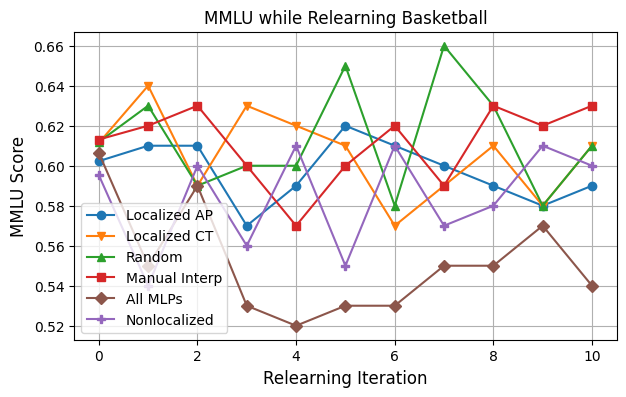

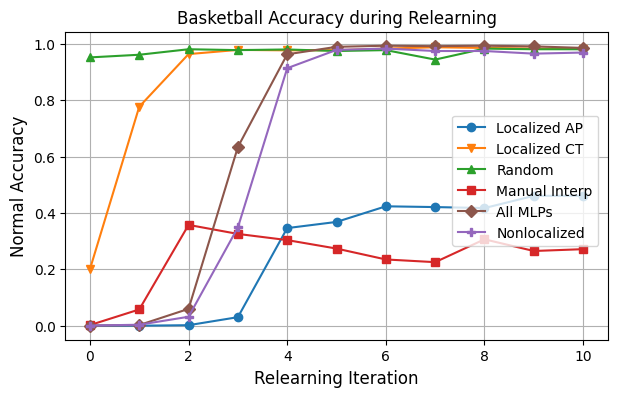

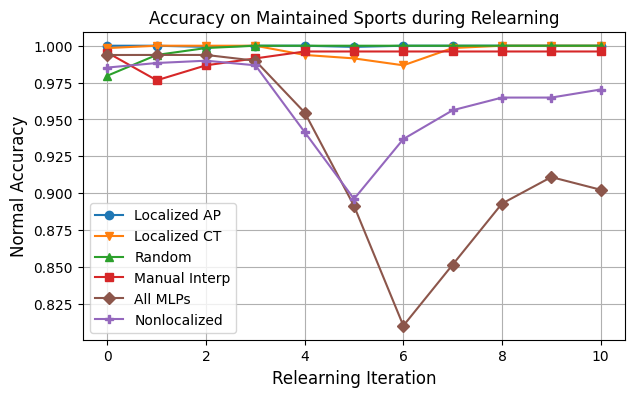

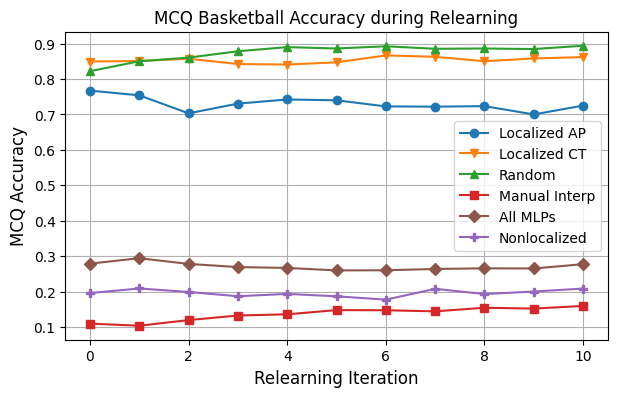

In [14]:
import matplotlib.pyplot as plt

# Function to plot relearning results
def plot_relearning_results(relearning_test_results, metric, title, ylabel, formal=True):
    plt.figure(figsize=(7, 4))
    for name, results in relearning_test_results.items():
        values = [result[metric] if metric != 'adversarial' else result[metric]['Normal']['forget'] for result in results]
        if formal:
            plt.plot(range(len(values)), values, label=formal_name_dict[name], marker=type_to_marker[name], color=color_map[name])
        else:
            plt.plot(range(len(values)), values, label=name, marker=type_to_marker[name])
    plt.xlabel('Relearning Iteration', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot MMLU
plot_relearning_results(relearning_test_results, 'MMLU', 'MMLU while Relearning Basketball', 'MMLU Score')

# Plot adversarial-normal-forget
def plot_adversarial_results(relearning_test_results, adversarial_type, forget_or_maintain, title, ylabel, formal=True, legend_kwargs={}):
    plt.figure(figsize=(7, 4))
    for name, results in relearning_test_results.items():
        values = [result['adversarial'][adversarial_type][forget_or_maintain] for result in results]
        # plt.plot(range(len(values)), values, label=name, marker='o')
        if formal:
            plt.plot(range(len(values)), values, label=formal_name_dict[name], marker=type_to_marker[name], color=color_map[name])
        else:
            plt.plot(range(len(values)), values, label=name, marker=type_to_marker[name])
    plt.xlabel('Relearning Iteration', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.legend(**legend_kwargs)
    plt.grid(True)
    plt.show()

title_suffix = "during Relearning" if inject_sport is None else "during Relearning after Injection"

# Plot adversarial-normal-forget
# plt.legend(loc='upper left', bbox_to_anchor=(.7, .87))
if forget_sport is not None:
    plot_adversarial_results(relearning_test_results, 'Normal', 'forget', f'Basketball Accuracy {title_suffix}', 'Normal Accuracy', legend_kwargs={'loc': 'upper left', 'bbox_to_anchor': (.7, .75)})

    # Plot adversarial-normal-maintain
    plot_adversarial_results(relearning_test_results, 'Normal', 'maintain', f'Accuracy on Maintained Sports {title_suffix}', 'Normal Accuracy')

    # Plot adversarial-mc-forget
    plot_adversarial_results(relearning_test_results, 'MC', 'forget', f'MCQ Basketball Accuracy {title_suffix}', 'MCQ Accuracy')

else:
    plot_adversarial_results(relearning_test_results, 'Normal', 'forget', f'Forgotten Athlete Accuracy {title_suffix}', 'Normal Accuracy')

    # Plot adversarial-normal-maintain
    plot_adversarial_results(relearning_test_results, 'Normal', 'maintain', f'Accuracy on Maintained Athletes {title_suffix}', 'Normal Accuracy')

    # Plot adversarial-mc-forget
    plot_adversarial_results(relearning_test_results, 'MC', 'forget', f'MCQ Athlete Accuracy {title_suffix}', 'MCQ Accuracy')


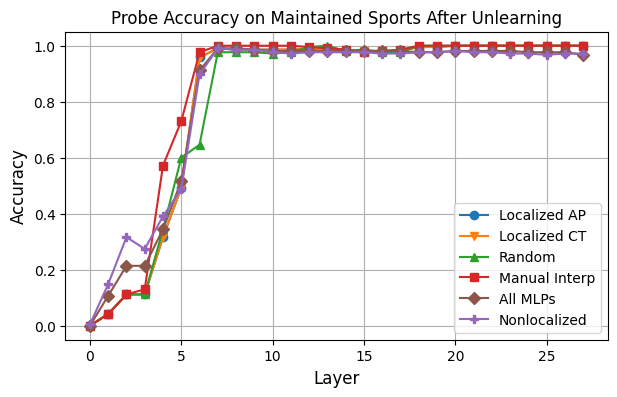

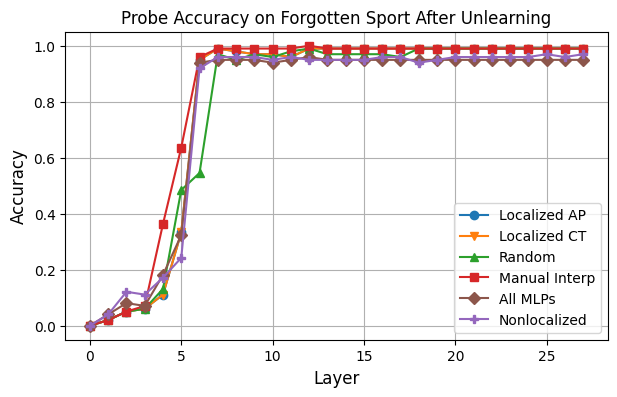

In [15]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# combine_heads = False #accidentally set this earlier, but its not actually False in the models
with open(f"{save_dir}/results/probes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pkl", "rb") as f:
    results = pickle.load(f)
    all_probes = results['all_probes']
    all_train_accs = results['all_train_accs']
    all_test_accs = results['all_test_accs']
    all_forget_accs = results['all_forget_accs']
    all_maintain_accs = results['all_maintain_accs']

combine_accuracies = True
# if combine_accuracies:
#     def plot_accuracies(all_train_accs, all_test_accs, all_forget_accs, all_maintain_accs):
#         for model_name in all_train_accs.keys():
#             layers = list(all_train_accs[model_name].keys())
#             train_accs = [all_train_accs[model_name][layer] for layer in layers]
#             test_accs = [all_test_accs[model_name][layer] for layer in layers]
#             forget_accs = [all_forget_accs[model_name][layer] for layer in layers]
#             maintain_accs = [all_maintain_accs[model_name][layer] for layer in layers]

#             plt.figure(figsize=(10, 6))
#             plt.plot(layers, train_accs, label='Train Accuracy', alpha=0.5, linestyle='--')
#             # plt.plot(layers, test_accs, label='Test Accuracy')
#             plt.plot(layers, forget_accs, label='Forget Accuracy')
#             plt.plot(layers, maintain_accs, label='Maintain Accuracy')
            
#             plt.xlabel('Layer')
#             plt.ylabel('Accuracy')
#             plt.title(f'Accuracy per Layer for {model_name}')
#             plt.legend()
#             plt.grid(True)
#             plt.show()

#     # Call the function to plot the accuracies
#     plot_accuracies(all_train_accs, all_test_accs, all_forget_accs, all_maintain_accs)

# else:
#     def plot_accuracies(all_train_accs, all_test_accs):
#         sports = ["baseball", "football", "basketball"]
        
#         for model_name in all_train_accs.keys():
#             layers = list(all_train_accs[model_name].keys())
            
#             plt.figure(figsize=(12, 8))
            
#             for sport in sports:
#                 train_accs = [all_train_accs[model_name][layer].get(sport, 0) for layer in layers]
#                 test_accs = [all_test_accs[model_name][layer].get(sport, 0) for layer in layers]
#                 # forget_accs = [all_forget_accs[model_name][layer].get(sport, 0) for layer in layers]
#                 # maintain_accs = [all_maintain_accs[model_name][layer].get(sport, 0) for layer in layers]
                
#                 plt.plot(layers, train_accs, label=f'Train Accuracy - {sport}', linestyle='--', alpha=0.5)
#                 plt.plot(layers, test_accs, label=f'Test Accuracy - {sport}')
#                 # plt.plot(layers, forget_accs, label=f'Forget Accuracy - {sport}')
#                 # plt.plot(layers, maintain_accs, label=f'Maintain Accuracy - {sport}')
            
#             plt.xlabel('Layer')
#             plt.ylabel('Accuracy')
#             plt.title(f'Accuracy per Layer for {model_name}')
#             plt.legend()
#             plt.grid(True)
#             plt.show()

#     # Call the function to plot the accuracies
#     plot_accuracies(all_train_accs, all_test_accs)
def plot_final_accuracies(all_accs, formal=True):
    # colors = plt.cm.get_cmap('tab10', len(all_train_accs))  # Get a colormap with enough colors for all models

    plt.figure(figsize=(7, 4))
    
    for idx, model_name in enumerate(all_train_accs.keys()):
        layers = list(all_train_accs[model_name].keys())
        accs = [all_accs[model_name][layer] for layer in layers]

        # plt.plot(layers, train_accs, label=f'{model_name} Train', color=colors(idx), linestyle=line_styles[0], alpha=0.5)
        # plt.plot(layers, forget_accs, label=f'{model_name} Forget', color=colors[idx], linestyle=line_styles[1])
        plt.plot(layers, accs, label=f'{formal_name_dict[model_name]}', color=color_map[model_name], marker=type_to_marker[model_name])
    
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)

# Call the function to plot the accuracies
plot_final_accuracies(all_maintain_accs)

title_suffix = "After Unlearning" if inject_sport is None else "After Injection"
if forget_sport is not None:
    plt.title(f'Probe Accuracy on Maintained Sports {title_suffix}')
else:
    plt.title(f'Probe Accuracy on Maintained Athletes {title_suffix}')
plt.legend()
plt.grid(True)
plt.show()

plot_final_accuracies(all_forget_accs)
# plt.title('Probe Accuracy on Forgotten Sport')
if forget_sport is not None:
    plt.title(f'Probe Accuracy on Forgotten Sport {title_suffix}')
else:
    plt.title(f'Probe Accuracy on Forgotten Athletes {title_suffix}')
plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(.7, .87))
plt.grid(True)
plt.show()

## Getting Numerical Evals

In [11]:
# combine_heads = False
model_paths_dict = {
    localization_type: f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt" for localization_type in localization_types
}
def model_init_and_load_func(mask_type):
    model_path = model_paths_dict[mask_type]
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
        model.load_state_dict(torch.load(model_path))
        return model
    return get_model_fn
model_init_and_load_funcs = {mask_type: model_init_and_load_func(mask_type) for mask_type in localization_types}

### Accuracies

In [6]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals

eval_batch_size=32
n_eval_iters = 10
device = "cuda"

forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}

task_losses = {}
task_accuracies = {}
adversarial_evals = {}
side_effect_evals = {}

for name in model_init_and_load_funcs.keys():
    print(f"Running eval for {name}")

    model = model_init_and_load_funcs[name]()
    model.cuda()
    task_losses[name] = {}
    task_accuracies[name] = {}
    for task_name, task in eval_tasks.items():
        task_loss = 0
        task_accuracy = 0
        for i in range(n_eval_iters):
            task_loss += task.get_test_loss(model).item()
            task_accuracy += task.get_test_accuracy(model)
        task_losses[name][task_name] = task_loss / n_eval_iters
        task_accuracies[name][task_name] = task_accuracy / n_eval_iters


    final_adversarial_eval = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                                                          forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                                                          maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                                                          continuous=True,
                                                          )

    adversarial_evals[name] = final_adversarial_eval

    final_side_effects = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Sports Familiarity"], verbose=False, eval_model="gpt-4o")
    side_effect_evals[name] = final_side_effects

    model.cpu()
    del model

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
Running eval for localized_ap


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for localized_ct


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for random


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for manual_interp


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for all_mlps


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for nonlocalized


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [7]:
adversarial_evals

{'localized_ap': {'Normal': {'forget': 4.695355892181397e-06, 'maintain': 1.0},
  'MC': {'forget': 0.7671874999999999, 'maintain': 0.9390625},
  'Capitalized': {'forget': 0.00024160146713256834, 'maintain': 1.0},
  'Dashed': {'forget': 0.8532724618911743, 'maintain': 0.9369702339172363}},
 'localized_ct': {'Normal': {'forget': 0.2005859375,
   'maintain': 0.9984374999999999},
  'MC': {'forget': 0.84921875, 'maintain': 0.95390625},
  'Capitalized': {'forget': 0.19594726562499998,
   'maintain': 0.9984374999999999},
  'Dashed': {'forget': 0.8742952346801758, 'maintain': 0.9667640686035155}},
 'random': {'Normal': {'forget': 0.95234375, 'maintain': 0.9796874999999999},
  'MC': {'forget': 0.821875, 'maintain': 0.940625},
  'Capitalized': {'forget': 0.9421875000000001,
   'maintain': 0.9843750000000001},
  'Dashed': {'forget': 0.9577271938323975, 'maintain': 0.6906817317008972}},
 'manual_interp': {'Normal': {'forget': 0.00219879150390625,
   'maintain': 0.9953125},
  'MC': {'forget': 0.110

In [8]:
task_accuracies

{'localized_ap': {'induction': 0.996875,
  'pile': 0.5323356747627258,
  'forget_sport': 7.862108759582043e-08,
  'maintain_sport': 1.0},
 'localized_ct': {'induction': 0.990625,
  'pile': 0.52143974006176,
  'forget_sport': 7.241964340209961e-05,
  'maintain_sport': 0.99921875},
 'random': {'induction': 0.99375,
  'pile': 0.5284130960702896,
  'forget_sport': 0.671484375,
  'maintain_sport': 0.97734375},
 'manual_interp': {'induction': 0.996875,
  'pile': 0.5355621635913849,
  'forget_sport': 2.9551982879638673e-05,
  'maintain_sport': 1.0},
 'all_mlps': {'induction': 0.99375,
  'pile': 0.5290896236896515,
  'forget_sport': 0.0002895355224609375,
  'maintain_sport': 1.0},
 'nonlocalized': {'induction': 0.984375,
  'pile': 0.5228466093540192,
  'forget_sport': 0.0004395723342895508,
  'maintain_sport': 0.988671875}}

In [9]:
with open(f"{save_dir}/eval_metrics.pkl", "wb") as f:
    pickle.dump({"task_losses": task_losses, "task_accuracies": task_accuracies, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)

In [10]:
with open(f"{save_dir}/eval_metrics.pkl", "rb") as f:
    eval_metrics = pickle.load(f)
    task_losses = eval_metrics["task_losses"]
    task_accuracies = eval_metrics["task_accuracies"]
    adversarial_evals = eval_metrics["adversarial_evals"]
    side_effect_evals = eval_metrics["side_effect_evals"]


In [11]:
task_accuracies

{'localized_ap': {'induction': 0.996875,
  'pile': 0.5323356747627258,
  'forget_sport': 7.862108759582043e-08,
  'maintain_sport': 1.0},
 'localized_ct': {'induction': 0.990625,
  'pile': 0.52143974006176,
  'forget_sport': 7.241964340209961e-05,
  'maintain_sport': 0.99921875},
 'random': {'induction': 0.99375,
  'pile': 0.5284130960702896,
  'forget_sport': 0.671484375,
  'maintain_sport': 0.97734375},
 'manual_interp': {'induction': 0.996875,
  'pile': 0.5355621635913849,
  'forget_sport': 2.9551982879638673e-05,
  'maintain_sport': 1.0},
 'all_mlps': {'induction': 0.99375,
  'pile': 0.5290896236896515,
  'forget_sport': 0.0002895355224609375,
  'maintain_sport': 1.0},
 'nonlocalized': {'induction': 0.984375,
  'pile': 0.5228466093540192,
  'forget_sport': 0.0004395723342895508,
  'maintain_sport': 0.988671875}}

In [12]:
{key: adversarial_evals[key]['MC'] for key in adversarial_evals.keys()}

{'localized_ap': {'forget': 0.7671874999999999, 'maintain': 0.9390625},
 'localized_ct': {'forget': 0.84921875, 'maintain': 0.95390625},
 'random': {'forget': 0.821875, 'maintain': 0.940625},
 'manual_interp': {'forget': 0.11005859375, 'maintain': 0.65625},
 'all_mlps': {'forget': 0.279296875, 'maintain': 0.31875},
 'nonlocalized': {'forget': 0.1962890625, 'maintain': 0.284765625}}

### MMLU

In [11]:
import lm_eval
from lm_eval import evaluate
from lm_eval.models.huggingface import HFLM

print(f"{save_dir=}")
try:
    with open(f"{save_dir}/full_capability_dict.pkl", "rb") as f:
        capability_dict = pickle.load(f)
except:
    print(f"Couldn't load capability dict from {save_dir}/full_capability_dict.pkl")
    capability_dict = {}

# for name in model_init_and_load_funcs.keys():
for name in ["nonlocalized"]:
    print(f"Running MMLU eval for {name}")

    hf_model = model_init_and_load_funcs[name]()
    hf_model.cuda()

    model = HFLM(pretrained=hf_model, dtype=torch.bfloat16, device="cuda")

    results = lm_eval.simple_evaluate(
        model=model,
        tasks=["mmlu", "sciq"]
    )
    capability_dict[name] = results['results']
    with open(f"{save_dir}/full_capability_dict.pkl", "wb") as f:
        pickle.dump(capability_dict, f)

    # model.cpu()
    del model
    hf_model.cpu()
    del hf_model


save_dir='results/localized_finetuning_16_athletes'
Running MMLU eval for nonlocalized


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-06-28:04:32:38,677 WARNING  [huggingface.py:121] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-06-28:04:32:39,846 INFO     [huggingface.py:279] Model type is 'gemma', a BOS token will be used as Gemma underperforms without it.
2024-06-28:04:32:39,846 WARNING  [huggingface.py:344] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-06-28:04:32:39,848 INFO     [evaluator.py:141] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-06-28:04:32:39,848 INFO     [evaluator.py:192] Using pre-initialized model
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for hails/mmlu_no_train contains custom code which must be executed to correctly load

In [12]:
with open(f"{save_dir}/full_capability_dict.pkl", "rb") as f:
    capability_dict = pickle.load(f)
mmlus = {name: results['mmlu'] for name, results in capability_dict.items()}
mmlus

{'localized_ap': {'acc,none': 0.6140150975644495,
  'acc_stderr,none': 0.003859784156761291,
  'alias': 'mmlu'},
 'localized_ct': {'acc,none': 0.6120922945449366,
  'acc_stderr,none': 0.0038644193047982153,
  'alias': 'mmlu'},
 'random': {'acc,none': 0.6119498646916394,
  'acc_stderr,none': 0.0038572201522997195,
  'alias': 'mmlu'},
 'manual_interp': {'acc,none': 0.6147984617575843,
  'acc_stderr,none': 0.0038475944903230514,
  'alias': 'mmlu'},
 'all_mlps': {'acc,none': 0.5986326734083464,
  'acc_stderr,none': 0.003892662263140642,
  'alias': 'mmlu'},
 'nonlocalized': {'acc,none': 0.5400227887765275,
  'acc_stderr,none': 0.004024606796313799,
  'alias': 'mmlu'}}